# CWRU Bearing Fault Diagnosis with Scalogram Inputs
## Overview
- **Dataset**: CWRU Bearing Data (1HP load, various fault types and sizes)
- **Input**: 96x96 pixel spectrogram or scalogram images
- **Model**: CNN with three stages of double conv layers (32, 64, 128 filters), max pooling, and two dense layers
- **Training**: 5-fold stratified cross-validation with early stopping
- **Evaluation**: Accuracy, confusion matrices, precision, recall, F1 score

## Requirements
- Python libraries: tensorflow, numpy, scipy, scikit-learn, matplotlib, seaborn, pywt, skimage
- CWRU dataset files in 'CWRU_BearingData_Load_1HP' folder

Run cells sequentially to load data, preprocess, train the model, and evaluate results.

In [2]:
# Setup for Reproducibility
import tensorflow as tf
import numpy as np
import random
import os

# Set a fixed seed value for reproducibility
SEED = 1
random.seed(SEED)            # Python random module
np.random.seed(SEED)         # NumPy
tf.random.set_seed(SEED)     # TensorFlow

# Enforce deterministic behavior for GPU operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'  # Ensure deterministic execution
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # Deterministic cuDNN algorithms

# Control GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)  # Enable memory growth

# Restrict parallelism
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Import additional libraries
import scipy.io
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from skimage.transform import resize
import pywt  # For wavelet transform

## Load CWRU Bearing Data

The `ImportData` function loads the CWRU dataset files (.mat) containing vibration signals for normal and fault conditions (inner race, ball, outer race) at various fault sizes under a 2HP load. The data is stored in a list for further processing.

In [4]:
def ImportData():
    folder_path = 'CWRU_BearingData_Load_1HP'
    file_paths = [
        os.path.join(folder_path, '98.mat'),
        os.path.join(folder_path, '110.mat'),
        os.path.join(folder_path, '123.mat'),
        os.path.join(folder_path, '136.mat'),
        os.path.join(folder_path, '175.mat'),
        os.path.join(folder_path, '190.mat'),
        os.path.join(folder_path, '202.mat'),
        os.path.join(folder_path, '214.mat'),
        os.path.join(folder_path, '227.mat'),
        os.path.join(folder_path, '239.mat')
    ]
    data_keys = [
        'X098_DE_time', 'X110_DE_time', 'X123_DE_time', 'X136_DE_time',
        'X175_DE_time', 'X190_DE_time', 'X202_DE_time', 'X214_DE_time',
        'X227_DE_time', 'X239_DE_time'
    ]
    data = [scipy.io.loadmat(fp)[key] for fp, key in zip(file_paths, data_keys)]
    return data



## Time-Frequency Image Generation

The following functions generate spectrogram and scalogram images from vibration signal segments, as per Verstraete et al. (2017):
- **Spectrogram**: Uses Short-Time Fourier Transform (STFT) with a Hann window, 256-point segments, and 128-point overlap. Images are normalized and resized to 96x96 pixels.
- **Scalogram**: Uses Continuous Wavelet Transform (CWT) with the Morlet wavelet, scales 1 to 128. Magnitude is normalized and resized to 96x96 pixels.

In [9]:
def min_max_norm(ary):
    ary = (ary - ary.min()) / np.abs(ary.max() - ary.min())
    return ary

def generate_spectrogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the spectrogram of an array data_y_vector and resize it to image_shape.
    """
    fs = 48000
    f, t, sxx = signal.spectrogram(
        data_y_vector,
        fs,
        nperseg=256,
        # noverlap=128,
        window='hann'
    )
    sxx = min_max_norm(sxx)
    sxx = resize(sxx, image_shape, mode='constant', anti_aliasing=True)
    return sxx

def generate_scalogram_image(data_y_vector, image_shape=(96, 96)):
    """
    Calculate the scalogram using Morlet wavelet and resize it to image_shape.
    """
    fs = 48000
    scales = np.arange(1, 128)  # Adjust scales for Morlet wavelet
    coef, freqs = pywt.cwt(
        data_y_vector,
        scales,
        'morl',
        sampling_period=1/fs
    )
    coef = np.abs(coef)  # Use magnitude
    coef = min_max_norm(coef)
    coef = resize(coef, image_shape, mode='constant', anti_aliasing=True)
    return coef

## Data Preprocessing

The `Sampling` function segments the vibration signals into blocks, and `DataPreparation` generates spectrogram or scalogram images for each segment. Labels are created in one-hot encoded format (`Y_CNN`) for CNN training and as integers (`Y`) for stratification. The output is a 4D array of images and corresponding labels.

In [6]:
def Sampling(Data, interval_length, samples_per_block, ignore_points=0):
    adjusted_length = len(Data) - 2 * ignore_points
    No_of_blocks = (round(adjusted_length / interval_length) - round(samples_per_block / interval_length) - 1)
    SplitData = np.zeros([No_of_blocks, samples_per_block])
    for i in range(No_of_blocks):
        start_idx = ignore_points + i * interval_length
        SplitData[i, :] = Data[start_idx:(start_idx + samples_per_block)].T
    return SplitData

def DataPreparation(Data, interval_length, samples_per_block, image_type='scalogram'):
    """
    Prepare data by generating spectrogram or scalogram images.
    """
    X = []
    LabelPositional = []
    Label = []
    for count, data in enumerate(Data):
        SplitData = Sampling(data, interval_length, samples_per_block)
        images = []
        for segment in SplitData:
            if image_type == 'spectrogram':
                img = generate_spectrogram_image(segment)
            elif image_type == 'scalogram':
                img = generate_scalogram_image(segment)
            images.append(img)
        images = np.array(images)
        y = np.zeros([len(SplitData), 10])
        y[:, count] = 1
        y1 = np.zeros([len(SplitData), 1])
        y1[:, 0] = count
        X.append(images)
        LabelPositional.append(y)
        Label.append(y1)
    X = np.concatenate(X, axis=0)
    LabelPositional = np.concatenate(LabelPositional, axis=0)
    Label = np.concatenate(Label, axis=0)
    return X, LabelPositional, Label

## CNN Model Definition

The `CNN_2D` class defines the CNN architecture as per Verstraete et al. (2017):
- Three stages, each with two convolutional layers (32, 64, 128 filters, 3x3 kernels) followed by 2x2 max pooling.
- Two dense layers (100 units each) with dropout (0.5) before the second dense layer.
- Output layer with 10 units (softmax) for 10-class classification.
- Compiled with Adam optimizer and categorical crossentropy loss.

In [7]:
class CNN_2D():
    def __init__(self):
        self.model = self.CreateModel()

    def CreateModel(self):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(96, 96, 1)),
            layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
            layers.MaxPool2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(100, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(96, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

## Main Execution

This section executes the pipeline:
- Loads and preprocesses data to generate 96x96 images (spectrogram or scalogram).
- Splits data into training (80%) and test (20%) sets with stratification.
- Performs 5-fold cross-validation with early stopping and model checkpointing.
- Saves the best model for each fold.

**Parameters**:
- `image_type`: Set to 'scalogram' or 'spectrogram' to choose input type.
- `image_shape`: 96x96 pixels for high accuracy (per Verstraete et al.).
- `kSplits`: 5 for cross-validation.
- `foldername`: Directory to save model checkpoints.

In [11]:
# Parameters
interval_length = 1600
samples_per_block = 1600
image_type = 'scalogram'  # Change to 'spectrogram' to use spectrograms
image_shape = (96, 96)
kSplits = 5
foldername = "CNN2D_results/Scalogram-HP1/"

from tensorflow.keras.callbacks import ModelCheckpoint #Saves the model with the highest validation accuracy for each fold
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.models import load_model 

# Load and prepare data
Data = ImportData()
X, Y_CNN, Y = DataPreparation(Data, interval_length, samples_per_block, image_type=image_type)
Input_2D = X.reshape([-1, image_shape[0], image_shape[1], 1])
print(f"Shape of Input Data: {Input_2D.shape}")

# Train-test split
X_2D_train, X_2D_test, y_2D_train, y_2D_test, y_label_train, y_label_test = train_test_split(
    Input_2D, Y_CNN, Y, train_size=0.8, test_size=0.2, random_state=42, stratify=Y
)

Shape of Input Data: (2954, 96, 96, 1)


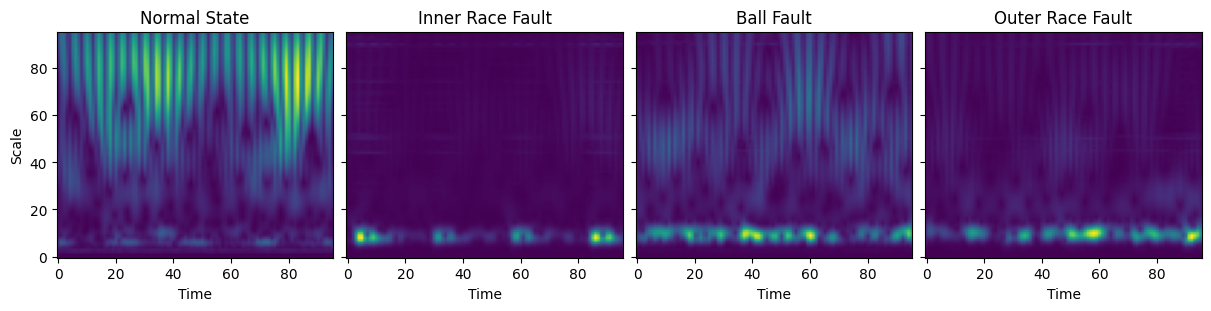

In [12]:
# Create a figure with four subplots, sharing the y-axis
fig, (plt1, plt2, plt3, plt4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3), constrained_layout=True)

# Plot Normal state scalogram (index 0, assuming Normal samples are at the start)
plt1.set_xlabel("Time")
plt1.set_ylabel("Scale")
plt1.set_title('Normal State')
plt1.imshow(Input_2D[0, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Inner Race fault scalogram (index 1000, assuming Inner Race samples around this index)
plt2.set_xlabel("Time")
plt2.set_title('Inner Race Fault')
plt2.imshow(Input_2D[1000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Ball fault scalogram (index 2000, assuming Ball fault samples around this index)
plt3.set_xlabel("Time")
plt3.set_title('Ball Fault')
plt3.imshow(Input_2D[2000, :, :], aspect='auto', origin='lower', cmap='viridis')

# Plot Outer Race fault scalogram (index 2500, assuming Outer Race samples around this index)
plt4.set_xlabel("Time")
plt4.set_title('Outer Race Fault')
plt4.imshow(Input_2D[2500, :, :], aspect='auto', origin='lower', cmap='viridis')

In [14]:
# K-fold cross-validation
from sklearn.metrics import precision_score, recall_score, f1_score

kfold = StratifiedKFold(n_splits=kSplits, random_state=42, shuffle=True)
accuracy_train = []
accuracy_val = []
accuracy_test = []
precision_val = []
recall_val = []
f1_val = []
pred_all_val = np.zeros([len(X_2D_train), 10])
y_2D_val = np.zeros([len(X_2D_train), 10])
kfold_test_len = []
fl1 = 0
k = 1

early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)

# Train the model
for fold, (train, test) in enumerate(kfold.split(X_2D_train, y_label_train)):
    checkpoint_filepath = foldername + f"best_model_{k}.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    Classification_2D = CNN_2D()
    history = Classification_2D.model.fit(
        X_2D_train[train], y_2D_train[train],
        validation_data=(X_2D_train[test], y_2D_train[test]),
        epochs=200,
        verbose=1,
        callbacks=[checkpoint, early_stop]
    )
    print(f"Best model saved at: {checkpoint_filepath}")
    CNN_2D_best_model = load_model(checkpoint_filepath)
    print("Best model loaded successfully!")
    
    fl2 = fl1 + len(test)
    pred_all_val[fl1:fl2, :] = CNN_2D_best_model.predict(X_2D_train[test])
    y_2D_val[fl1:fl2, :] = y_2D_train[test]
    kfold_test_len.append(fl2 - fl1)
    fl1 = fl2

    train_loss, train_accuracy = CNN_2D_best_model.evaluate(X_2D_train[train], y_2D_train[train])
    accuracy_train.append(train_accuracy)
    val_loss, val_accuracy = CNN_2D_best_model.evaluate(X_2D_train[test], y_2D_train[test])
    accuracy_val.append(val_accuracy)
    test_loss, test_accuracy = CNN_2D_best_model.evaluate(X_2D_test, y_2D_test)
    accuracy_test.append(test_accuracy)

    # Calculate precision, recall, and F1 score for validation set
    y_pred_val = np.argmax(CNN_2D_best_model.predict(X_2D_train[test]), axis=1)
    y_true_val = np.argmax(y_2D_train[test], axis=1)
    precision_val.append(precision_score(y_true_val, y_pred_val, average='weighted'))
    recall_val.append(recall_score(y_true_val, y_pred_val, average='weighted'))
    f1_val.append(f1_score(y_true_val, y_pred_val, average='weighted'))


    
    k += 1

/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-16 16:13:24.721156: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 16:13:24.722001: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2783 - loss: 1.9343

2025-06-16 16:14:40.123289: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 16:14:40.124233: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.78224, saving model to CNN2D_results/Scalogram-HP1/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.2807 - loss: 1.9277 - val_accuracy: 0.7822 - val_loss: 0.6248
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7683 - loss: 0.6725
Epoch 2: val_accuracy did not improve from 0.78224
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.7688 - loss: 0.6712 - val_accuracy: 0.7294 - val_loss: 0.7510
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8230 - loss: 0.4769
Epoch 3: val_accuracy improved from 0.78224 to 0.92178, saving model to CNN2D_results/Scalogram-HP1/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8233 - loss: 0.4758 - val_accuracy: 0.9218 - val_loss: 0.2068
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8735 - loss: 0.3313
Epoch 4: val_accuracy improved from 0.92178 to 0.97040, saving model to CNN2D_results/Scalogram-HP1/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.8737 - loss: 0.3308 - val_accuracy: 0.9704 - val_loss: 0.0972
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9143 - loss: 0.2392
Epoch 5: val_accuracy improved from 0.97040 to 0.97252, saving model to CNN2D_results/Scalogram-HP1/best_model_1.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9144 - loss: 0.2390 - val_accuracy: 0.9725 - val_loss: 0.0977
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9109 - loss: 0.2478
Epoch 6: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9110 - loss: 0.2479 - val_accuracy: 0.9619 - val_loss: 0.0960
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9308 - loss: 0.1765
Epoch 7: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9307 - loss: 0.1768 - val_accuracy: 0.9704 - val_loss: 0.0984
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9410 - loss: 0.1674
Epoch 8: val_accuracy did not improve from 0.97252
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9409 - loss: 0.1675 - val_accuracy: 0.9619 - val_loss: 0.1068
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9478 - loss: 0.1475
Epoch 9: val_accuracy improved from 0.97252 to 0.97

60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9477 - loss: 0.1477 - val_accuracy: 0.9767 - val_loss: 0.0723
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9482 - loss: 0.1241
Epoch 10: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9484 - loss: 0.1238 - val_accuracy: 0.9493 - val_loss: 0.1450
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9503 - loss: 0.1472
Epoch 11: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9503 - loss: 0.1474 - val_accuracy: 0.9577 - val_loss: 0.1468
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9500 - loss: 0.1490
Epoch 12: val_accuracy did not improve from 0.97674
60/60 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9501 - loss: 0.1487 - val_accuracy: 0.9767 - val_loss: 0.0650
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9665 - loss: 0.1066
Epoch 13: val_accuracy improved from 0.97674

60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9665 - loss: 0.1066 - val_accuracy: 0.9831 - val_loss: 0.0716
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9676 - loss: 0.0954
Epoch 14: val_accuracy did not improve from 0.98309
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9675 - loss: 0.0957 - val_accuracy: 0.9662 - val_loss: 0.1289
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9462 - loss: 0.1663
Epoch 15: val_accuracy did not improve from 0.98309
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9462 - loss: 0.1662 - val_accuracy: 0.9810 - val_loss: 0.0898
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9688 - loss: 0.0777
Epoch 16: val_accuracy did not improve from 0.98309
60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.9687 - loss: 0.0781 - val_accuracy: 0.9641 - val_loss: 0.1237
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9647 - loss: 0.1189
Epoch 17: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9669 - loss: 0.1014 - val_accuracy: 0.9852 - val_loss: 0.0578
Epoch 27/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9876 - loss: 0.0424
Epoch 27: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9875 - loss: 0.0427 - val_accuracy: 0.9725 - val_loss: 0.0994
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9789 - loss: 0.0497
Epoch 28: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9790 - loss: 0.0497 - val_accuracy: 0.9831 - val_loss: 0.0557
Epoch 29/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9858 - loss: 0.0466
Epoch 29: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9857 - loss: 0.0466 - val_accuracy: 0.9831 - val_loss: 0.0866
Epoch 30/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9705 - loss: 0.0961
Epoch 30: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9812 - loss: 0.0473 - val_accuracy: 0.9873 - val_loss: 0.0535
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9913 - loss: 0.0305
Epoch 33: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9912 - loss: 0.0307 - val_accuracy: 0.9831 - val_loss: 0.0694
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9771 - loss: 0.0705
Epoch 34: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9771 - loss: 0.0706 - val_accuracy: 0.9831 - val_loss: 0.0390
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9716 - loss: 0.1059
Epoch 35: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9715 - loss: 0.1061 - val_accuracy: 0.9746 - val_loss: 0.0805
Epoch 36/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9788 - loss: 0.0551
Epoch 36: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9812 - loss: 0.0493 - val_accuracy: 0.9894 - val_loss: 0.0738
Epoch 47/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9836 - loss: 0.0477
Epoch 47: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9836 - loss: 0.0478 - val_accuracy: 0.9831 - val_loss: 0.1312
Epoch 48/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9872 - loss: 0.0434
Epoch 48: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9872 - loss: 0.0433 - val_accuracy: 0.9894 - val_loss: 0.0445
Epoch 49/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9898 - loss: 0.0257
Epoch 49: val_accuracy did not improve from 0.98943
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9898 - loss: 0.0258 - val_accuracy: 0.9831 - val_loss: 0.0725
Epoch 50/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9859 - loss: 0.0362
Epoch 50: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 271s 5s/step - accuracy: 0.9928 - loss: 0.0176 - val_accuracy: 0.9915 - val_loss: 0.0498
Epoch 90/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.9930 - loss: 0.0203 
Epoch 90: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 2296s 39s/step - accuracy: 0.9930 - loss: 0.0203 - val_accuracy: 0.9915 - val_loss: 0.0694
Epoch 91/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 195s/step - accuracy: 0.9972 - loss: 0.0105  
Epoch 91: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 12129s 206s/step - accuracy: 0.9972 - loss: 0.0106 - val_accuracy: 0.9831 - val_loss: 0.1171
Epoch 92/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9938 - loss: 0.0127
Epoch 92: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 278s 5s/step - accuracy: 0.9937 - loss: 0.0128 - val_accuracy: 0.9789 - val_loss: 0.1122
Epoch 93/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9896 - loss: 0.0201
Epoch 93: val_accuracy did n

Best model loaded successfully!


2025-06-16 23:16:41.932898: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 23:16:41.933816: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 376ms/step


2025-06-16 23:16:48.131130: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 23:16:48.131412: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 1.0000 - loss: 2.8871e-04


2025-06-16 23:17:10.787146: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 23:17:10.787447: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 375ms/step - accuracy: 0.9948 - loss: 0.0249


2025-06-16 23:17:16.582048: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 23:17:16.582345: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.9954 - loss: 0.0366


2025-06-16 23:17:23.556510: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-16 23:17:23.556759: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step
Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-16 23:17:29.375993: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2358 - loss: 1.9815

2025-06-16 23:18:41.850388: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-16 23:18:41.850697: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.80550, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.2383 - loss: 1.9758 - val_accuracy: 0.8055 - val_loss: 0.5522
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7119 - loss: 0.7471
Epoch 2: val_accuracy improved from 0.80550 to 0.96617, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7125 - loss: 0.7455 - val_accuracy: 0.9662 - val_loss: 0.1842
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8355 - loss: 0.4568
Epoch 3: val_accuracy did not improve from 0.96617
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8355 - loss: 0.4570 - val_accuracy: 0.9577 - val_loss: 0.1844
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8787 - loss: 0.3474
Epoch 4: val_accuracy improved from 0.96617 to 0.96829, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.8786 - loss: 0.3477 - val_accuracy: 0.9683 - val_loss: 0.0988
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8952 - loss: 0.2896
Epoch 5: val_accuracy did not improve from 0.96829
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8951 - loss: 0.2900 - val_accuracy: 0.9493 - val_loss: 0.1775
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8988 - loss: 0.2841
Epoch 6: val_accuracy improved from 0.96829 to 0.97463, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.8987 - loss: 0.2841 - val_accuracy: 0.9746 - val_loss: 0.0861
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9174 - loss: 0.2324
Epoch 7: val_accuracy did not improve from 0.97463
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9172 - loss: 0.2329 - val_accuracy: 0.9725 - val_loss: 0.1320
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9149 - loss: 0.2227
Epoch 8: val_accuracy improved from 0.97463 to 0.98520, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9150 - loss: 0.2227 - val_accuracy: 0.9852 - val_loss: 0.0560
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9399 - loss: 0.1711
Epoch 9: val_accuracy did not improve from 0.98520
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9398 - loss: 0.1713 - val_accuracy: 0.9746 - val_loss: 0.0557
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9481 - loss: 0.1501
Epoch 10: val_accuracy improved from 0.98520 to 0.98731, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9479 - loss: 0.1505 - val_accuracy: 0.9873 - val_loss: 0.0662
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9483 - loss: 0.1322
Epoch 11: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9482 - loss: 0.1324 - val_accuracy: 0.9852 - val_loss: 0.0638
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9554 - loss: 0.1124
Epoch 12: val_accuracy improved from 0.98731 to 0.99366, saving model to CNN2D_results/Scalogram-HP1/best_model_2.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9553 - loss: 0.1127 - val_accuracy: 0.9937 - val_loss: 0.0395
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9614 - loss: 0.1111
Epoch 13: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9612 - loss: 0.1115 - val_accuracy: 0.9852 - val_loss: 0.0462
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9519 - loss: 0.1322
Epoch 14: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9519 - loss: 0.1323 - val_accuracy: 0.9704 - val_loss: 0.0818
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9704 - loss: 0.0978
Epoch 15: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9703 - loss: 0.0979 - val_accuracy: 0.9894 - val_loss: 0.0556
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9657 - loss: 0.1041
Epoch 16: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 01:54:30.092758: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 01:54:30.093560: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step


2025-06-17 01:54:36.156121: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 01:54:36.156421: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.9951 - loss: 0.0254


2025-06-17 01:54:58.305088: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 01:54:58.305383: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 364ms/step - accuracy: 0.9967 - loss: 0.0322


2025-06-17 01:55:03.939184: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 01:55:03.939435: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.9932 - loss: 0.0286


2025-06-17 01:55:10.821252: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 01:55:10.821505: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 372ms/step
Epoch 1/200


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-17 01:55:16.660243: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown a

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3201 - loss: 1.8640

2025-06-17 01:56:29.029373: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 01:56:29.029644: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.79070, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.3224 - loss: 1.8575 - val_accuracy: 0.7907 - val_loss: 0.6772
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7002 - loss: 0.8278
Epoch 2: val_accuracy improved from 0.79070 to 0.83721, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7008 - loss: 0.8263 - val_accuracy: 0.8372 - val_loss: 0.5151
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7756 - loss: 0.6357
Epoch 3: val_accuracy improved from 0.83721 to 0.94080, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7761 - loss: 0.6343 - val_accuracy: 0.9408 - val_loss: 0.2665
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8521 - loss: 0.4086
Epoch 4: val_accuracy improved from 0.94080 to 0.95349, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8520 - loss: 0.4089 - val_accuracy: 0.9535 - val_loss: 0.1547
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8906 - loss: 0.2999
Epoch 5: val_accuracy improved from 0.95349 to 0.97040, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.8907 - loss: 0.2998 - val_accuracy: 0.9704 - val_loss: 0.1094
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9057 - loss: 0.2537
Epoch 6: val_accuracy did not improve from 0.97040
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9056 - loss: 0.2541 - val_accuracy: 0.9641 - val_loss: 0.1474
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9068 - loss: 0.2664
Epoch 7: val_accuracy improved from 0.97040 to 0.97886, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9068 - loss: 0.2664 - val_accuracy: 0.9789 - val_loss: 0.0774
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9229 - loss: 0.2003
Epoch 8: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9230 - loss: 0.2000 - val_accuracy: 0.9746 - val_loss: 0.0728
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.9285 - loss: 0.1882 
Epoch 9: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 1757s 30s/step - accuracy: 0.9285 - loss: 0.1883 - val_accuracy: 0.9683 - val_loss: 0.1180
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9429 - loss: 0.1435 
Epoch 10: val_accuracy did not improve from 0.97886
60/60 ━━━━━━━━━━━━━━━━━━━━ 1029s 17s/step - accuracy: 0.9430 - loss: 0.1434 - val_accuracy: 0.9746 - val_loss: 0.0602
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9439 - loss: 0.1589
Epoch 11: val_accuracy did not improve

60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9468 - loss: 0.1266 - val_accuracy: 0.9831 - val_loss: 0.0498
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9594 - loss: 0.1188
Epoch 15: val_accuracy improved from 0.98309 to 0.98731, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.9594 - loss: 0.1189 - val_accuracy: 0.9873 - val_loss: 0.0425
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.9569 - loss: 0.1148 
Epoch 16: val_accuracy did not improve from 0.98731
60/60 ━━━━━━━━━━━━━━━━━━━━ 1009s 17s/step - accuracy: 0.9569 - loss: 0.1149 - val_accuracy: 0.9852 - val_loss: 0.0555
Epoch 17/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9540 - loss: 0.1344
Epoch 17: val_accuracy improved from 0.98731 to 0.99154, saving model to CNN2D_results/Scalogram-HP1/best_model_3.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9540 - loss: 0.1342 - val_accuracy: 0.9915 - val_loss: 0.0398
Epoch 18/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.9733 - loss: 0.0890 
Epoch 18: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 2082s 35s/step - accuracy: 0.9731 - loss: 0.0896 - val_accuracy: 0.9746 - val_loss: 0.0588
Epoch 19/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9691 - loss: 0.0919
Epoch 19: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9690 - loss: 0.0919 - val_accuracy: 0.9915 - val_loss: 0.0272
Epoch 20/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9684 - loss: 0.0809
Epoch 20: val_accuracy did not improve from 0.99154
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9682 - loss: 0.0813 - val_accuracy: 0.9789 - val_loss: 0.0494
Epoch 21/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9542 - loss: 0.1098
Epoch 21: val_accuracy did not improve 

60/60 ━━━━━━━━━━━━━━━━━━━━ 988s 17s/step - accuracy: 0.9736 - loss: 0.0758 - val_accuracy: 0.9937 - val_loss: 0.0157
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9806 - loss: 0.0542
Epoch 34: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9806 - loss: 0.0543 - val_accuracy: 0.9852 - val_loss: 0.0555
Epoch 35/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9790 - loss: 0.0619
Epoch 35: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 1013s 17s/step - accuracy: 0.9789 - loss: 0.0620 - val_accuracy: 0.9915 - val_loss: 0.0301
Epoch 36/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9772 - loss: 0.0570
Epoch 36: val_accuracy did not improve from 0.99366
60/60 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9773 - loss: 0.0569 - val_accuracy: 0.9831 - val_loss: 0.0430
Epoch 37/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9724 - loss: 0.0729
Epoch 37: val_accuracy did not improve 

60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9843 - loss: 0.0480 - val_accuracy: 0.9958 - val_loss: 0.0183
Epoch 83/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9900 - loss: 0.0277
Epoch 83: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9900 - loss: 0.0278 - val_accuracy: 0.9958 - val_loss: 0.0247
Epoch 84/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9933 - loss: 0.0194
Epoch 84: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9932 - loss: 0.0195 - val_accuracy: 0.9937 - val_loss: 0.0255
Epoch 85/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9928 - loss: 0.0229
Epoch 85: val_accuracy did not improve from 0.99577
60/60 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9928 - loss: 0.0229 - val_accuracy: 0.9894 - val_loss: 0.0207
Epoch 86/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9969 - loss: 0.0114
Epoch 86: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 11:00:21.600341: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 11:00:21.603265: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 465ms/step


2025-06-17 11:00:29.279209: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:00:29.280256: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 27s 443ms/step - accuracy: 1.0000 - loss: 3.7702e-05


2025-06-17 11:00:56.247156: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:00:56.248001: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step - accuracy: 0.9969 - loss: 0.0140


2025-06-17 11:01:02.797724: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:01:02.798032: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 490ms/step - accuracy: 0.9892 - loss: 0.0451


2025-06-17 11:01:12.127040: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 11:01:12.127371: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 11:01:18.646570: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:01:18.646887: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2432 - loss: 2.0403

2025-06-17 11:02:43.247603: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 11:02:43.248357: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.86017, saving model to CNN2D_results/Scalogram-HP1/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.2455 - loss: 2.0344 - val_accuracy: 0.8602 - val_loss: 0.5049
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7192 - loss: 0.7401
Epoch 2: val_accuracy improved from 0.86017 to 0.92585, saving model to CNN2D_results/Scalogram-HP1/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.7199 - loss: 0.7383 - val_accuracy: 0.9258 - val_loss: 0.2242
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8235 - loss: 0.4762
Epoch 3: val_accuracy did not improve from 0.92585
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8239 - loss: 0.4751 - val_accuracy: 0.9025 - val_loss: 0.2306
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8489 - loss: 0.3793
Epoch 4: val_accuracy did not improve from 0.92585
60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8491 - loss: 0.3792 - val_accuracy: 0.9110 - val_loss: 0.2022
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8816 - loss: 0.3320
Epoch 5: val_accuracy improved from 0.92585 to 0.95339, saving model to CNN2D_results/Scalogram-HP1/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8817 - loss: 0.3318 - val_accuracy: 0.9534 - val_loss: 0.1161
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8960 - loss: 0.2601
Epoch 6: val_accuracy improved from 0.95339 to 0.97034, saving model to CNN2D_results/Scalogram-HP1/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8958 - loss: 0.2608 - val_accuracy: 0.9703 - val_loss: 0.0841
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8956 - loss: 0.2772
Epoch 7: val_accuracy improved from 0.97034 to 0.97458, saving model to CNN2D_results/Scalogram-HP1/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8958 - loss: 0.2768 - val_accuracy: 0.9746 - val_loss: 0.0790
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9353 - loss: 0.1848
Epoch 8: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9352 - loss: 0.1851 - val_accuracy: 0.9661 - val_loss: 0.0860
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9115 - loss: 0.2556
Epoch 9: val_accuracy did not improve from 0.97458
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9115 - loss: 0.2554 - val_accuracy: 0.9619 - val_loss: 0.1064
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9256 - loss: 0.2135
Epoch 10: val_accuracy improved from 0.97458 to 0.98941, saving model to CNN2D_results/Scalogram-HP1/best_model_4.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9256 - loss: 0.2135 - val_accuracy: 0.9894 - val_loss: 0.0603
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9384 - loss: 0.1684
Epoch 11: val_accuracy did not improve from 0.98941
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9381 - loss: 0.1691 - val_accuracy: 0.9703 - val_loss: 0.0811
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9154 - loss: 0.2055
Epoch 12: val_accuracy did not improve from 0.98941
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9155 - loss: 0.2054 - val_accuracy: 0.9809 - val_loss: 0.0667
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9229 - loss: 0.1988
Epoch 13: val_accuracy did not improve from 0.98941
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9230 - loss: 0.1986 - val_accuracy: 0.9449 - val_loss: 0.1320
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9266 - loss: 0.1899
Epoch 14: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9636 - loss: 0.0927 - val_accuracy: 0.9936 - val_loss: 0.0126
Epoch 23/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9564 - loss: 0.1226
Epoch 23: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9564 - loss: 0.1225 - val_accuracy: 0.9831 - val_loss: 0.0644
Epoch 24/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9646 - loss: 0.0975
Epoch 24: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9647 - loss: 0.0972 - val_accuracy: 0.9852 - val_loss: 0.0356
Epoch 25/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9731 - loss: 0.0877
Epoch 25: val_accuracy did not improve from 0.99364
60/60 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9730 - loss: 0.0880 - val_accuracy: 0.9809 - val_loss: 0.0554
Epoch 26/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9624 - loss: 0.1191
Epoch 26: val_accuracy did not improve fr

60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.9706 - loss: 0.0695 - val_accuracy: 0.9958 - val_loss: 0.0271
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9638 - loss: 0.0891
Epoch 31: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9638 - loss: 0.0891 - val_accuracy: 0.9809 - val_loss: 0.0465
Epoch 32/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9693 - loss: 0.0876
Epoch 32: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9693 - loss: 0.0875 - val_accuracy: 0.9894 - val_loss: 0.0341
Epoch 33/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9689 - loss: 0.0826
Epoch 33: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.9689 - loss: 0.0827 - val_accuracy: 0.9873 - val_loss: 0.0394
Epoch 34/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9706 - loss: 0.0765
Epoch 34: val_accuracy did not improve fr

60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9834 - loss: 0.0451 - val_accuracy: 0.9979 - val_loss: 0.0117
Epoch 55/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9717 - loss: 0.0802
Epoch 55: val_accuracy did not improve from 0.99788
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9716 - loss: 0.0806 - val_accuracy: 0.9767 - val_loss: 0.0942
Epoch 56/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9718 - loss: 0.0848
Epoch 56: val_accuracy did not improve from 0.99788
60/60 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9719 - loss: 0.0846 - val_accuracy: 0.9936 - val_loss: 0.0205
Epoch 57/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9740 - loss: 0.0628
Epoch 57: val_accuracy did not improve from 0.99788
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9741 - loss: 0.0626 - val_accuracy: 0.9915 - val_loss: 0.0226
Epoch 58/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9713 - loss: 0.0845
Epoch 58: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 14:02:19.016705: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 14:02:19.018561: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step


2025-06-17 14:02:25.903658: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 14:02:25.904101: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 25s 413ms/step - accuracy: 1.0000 - loss: 3.5709e-04


2025-06-17 14:02:51.126332: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 14:02:51.126657: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 395ms/step - accuracy: 0.9989 - loss: 0.0089


2025-06-17 14:02:57.300497: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 14:02:57.300876: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 396ms/step - accuracy: 0.9957 - loss: 0.0253


2025-06-17 14:03:04.889334: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 14:03:04.889699: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 396ms/step


/Users/Gayathri/pyenvs/tf-env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200


2025-06-17 14:03:11.185422: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 14:03:11.185784: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2345 - loss: 2.0038

2025-06-17 14:04:35.874682: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 14:04:35.875053: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),


Epoch 1: val_accuracy improved from -inf to 0.77119, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.2367 - loss: 1.9988 - val_accuracy: 0.7712 - val_loss: 0.6831
Epoch 2/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7003 - loss: 0.8315
Epoch 2: val_accuracy improved from 0.77119 to 0.86653, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7011 - loss: 0.8298 - val_accuracy: 0.8665 - val_loss: 0.3211
Epoch 3/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7880 - loss: 0.5779
Epoch 3: val_accuracy improved from 0.86653 to 0.94492, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7885 - loss: 0.5766 - val_accuracy: 0.9449 - val_loss: 0.1357
Epoch 4/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8570 - loss: 0.3867
Epoch 4: val_accuracy improved from 0.94492 to 0.95551, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8572 - loss: 0.3859 - val_accuracy: 0.9555 - val_loss: 0.0884
Epoch 5/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9085 - loss: 0.2636
Epoch 5: val_accuracy improved from 0.95551 to 0.96398, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9085 - loss: 0.2636 - val_accuracy: 0.9640 - val_loss: 0.0900
Epoch 6/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9010 - loss: 0.2719
Epoch 6: val_accuracy did not improve from 0.96398
60/60 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step - accuracy: 0.9012 - loss: 0.2715 - val_accuracy: 0.9576 - val_loss: 0.1249
Epoch 7/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9358 - loss: 0.1867
Epoch 7: val_accuracy did not improve from 0.96398
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9358 - loss: 0.1864 - val_accuracy: 0.9364 - val_loss: 0.1735
Epoch 8/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9236 - loss: 0.2105
Epoch 8: val_accuracy improved from 0.96398 to 0.96822, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9237 - loss: 0.2102 - val_accuracy: 0.9682 - val_loss: 0.0877
Epoch 9/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9344 - loss: 0.1710
Epoch 9: val_accuracy did not improve from 0.96822
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9345 - loss: 0.1709 - val_accuracy: 0.9576 - val_loss: 0.1137
Epoch 10/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9409 - loss: 0.1674
Epoch 10: val_accuracy did not improve from 0.96822
60/60 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.9408 - loss: 0.1676 - val_accuracy: 0.9068 - val_loss: 0.2485
Epoch 11/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8277 - loss: 0.5982
Epoch 11: val_accuracy improved from 0.96822 to 0.97458, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8285 - loss: 0.5946 - val_accuracy: 0.9746 - val_loss: 0.0731
Epoch 12/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9302 - loss: 0.1911
Epoch 12: val_accuracy improved from 0.97458 to 0.98517, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9303 - loss: 0.1909 - val_accuracy: 0.9852 - val_loss: 0.0389
Epoch 13/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9649 - loss: 0.0958
Epoch 13: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9649 - loss: 0.0958 - val_accuracy: 0.9703 - val_loss: 0.0589
Epoch 14/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9526 - loss: 0.1357
Epoch 14: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.9526 - loss: 0.1358 - val_accuracy: 0.9661 - val_loss: 0.0707
Epoch 15/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9513 - loss: 0.1484
Epoch 15: val_accuracy did not improve from 0.98517
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.9513 - loss: 0.1484 - val_accuracy: 0.9555 - val_loss: 0.1157
Epoch 16/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9518 - loss: 0.1249
Epoch 16: val_accuracy did not improve fro

60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9782 - loss: 0.0625 - val_accuracy: 0.9873 - val_loss: 0.0458
Epoch 26/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9765 - loss: 0.0791
Epoch 26: val_accuracy improved from 0.98729 to 0.98941, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9764 - loss: 0.0790 - val_accuracy: 0.9894 - val_loss: 0.0170
Epoch 27/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9785 - loss: 0.0548
Epoch 27: val_accuracy improved from 0.98941 to 0.99576, saving model to CNN2D_results/Scalogram-HP1/best_model_5.h5


60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9785 - loss: 0.0549 - val_accuracy: 0.9958 - val_loss: 0.0152
Epoch 28/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9760 - loss: 0.0730
Epoch 28: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9759 - loss: 0.0732 - val_accuracy: 0.9788 - val_loss: 0.0709
Epoch 29/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9754 - loss: 0.0632
Epoch 29: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9754 - loss: 0.0632 - val_accuracy: 0.9958 - val_loss: 0.0100
Epoch 30/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9712 - loss: 0.0880
Epoch 30: val_accuracy did not improve from 0.99576
60/60 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9712 - loss: 0.0879 - val_accuracy: 0.9894 - val_loss: 0.0245
Epoch 31/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9815 - loss: 0.0608
Epoch 31: val_accuracy did not improve from 

60/60 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.9779 - loss: 0.0569 - val_accuracy: 0.9979 - val_loss: 0.0086
Epoch 36/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9849 - loss: 0.0395
Epoch 36: val_accuracy did not improve from 0.99788
60/60 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.9849 - loss: 0.0395 - val_accuracy: 0.9873 - val_loss: 0.0400
Epoch 37/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9772 - loss: 0.0676
Epoch 37: val_accuracy did not improve from 0.99788
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9771 - loss: 0.0676 - val_accuracy: 0.9936 - val_loss: 0.0196
Epoch 38/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9858 - loss: 0.0383
Epoch 38: val_accuracy did not improve from 0.99788
60/60 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.9858 - loss: 0.0384 - val_accuracy: 0.9852 - val_loss: 0.0420
Epoch 39/200
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9801 - loss: 0.0523
Epoch 39: val_accuracy did not improve from 

Best model loaded successfully!


2025-06-17 16:19:17.423231: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:19:17.424549: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 415ms/step


2025-06-17 16:19:24.368522: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:19:24.368878: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 479ms/step - accuracy: 0.9979 - loss: 0.0045


2025-06-17 16:19:53.631868: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:19:53.632541: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 467ms/step - accuracy: 0.9984 - loss: 0.0050


2025-06-17 16:20:01.060559: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-06-17 16:20:01.060903: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 442ms/step - accuracy: 0.9881 - loss: 0.0263


2025-06-17 16:20:09.497562: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:20:09.497878: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 406ms/step


## Model Evaluation

Evaluate the trained model by computing average accuracies across folds for training, validation, and test sets. Visualize performance with confusion matrices for train and test sets, and bar plots for fold-wise and train vs. test accuracies.

CNN 2D train accuracy = 99.91535544395447
CNN 2D validation accuracy = 99.53470468521118
CNN 2D test accuracy = 99.22165870666504


2025-06-17 16:31:42.669846: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:31:42.671215: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

74/74 ━━━━━━━━━━━━━━━━━━━━ 35s 475ms/step


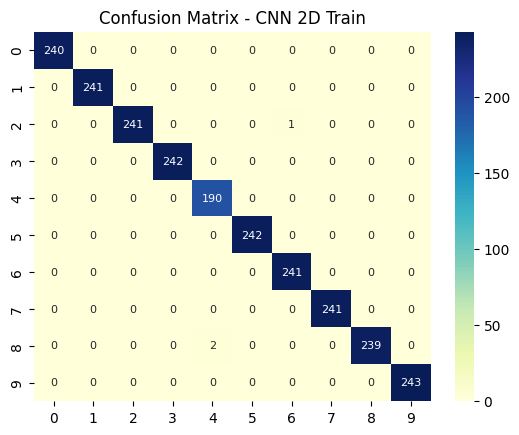

2025-06-17 16:32:18.603870: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:32:18.604811: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step


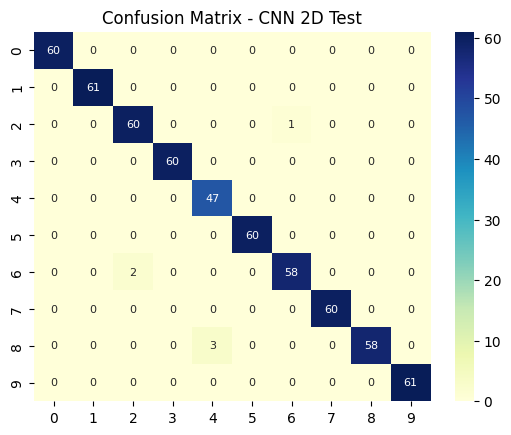

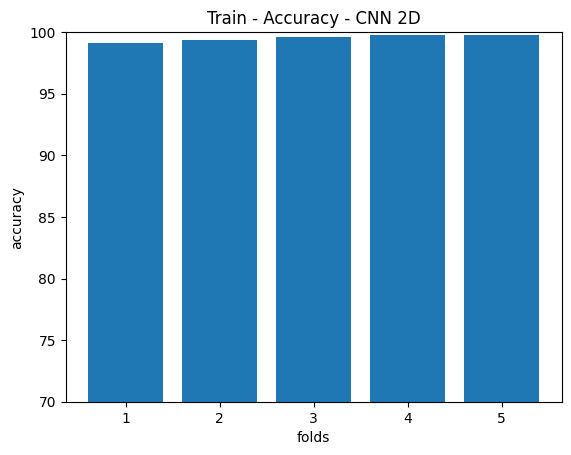

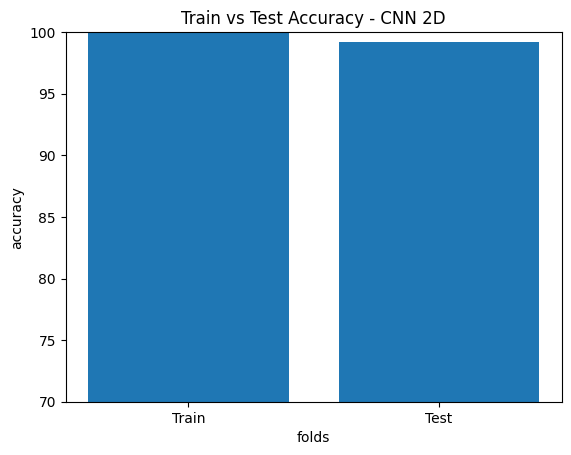

In [15]:
CNN_2D_train_accuracy = np.average(accuracy_train) * 100
print(f'CNN 2D train accuracy = {CNN_2D_train_accuracy}')
CNN_2D_val_accuracy = np.average(accuracy_val) * 100
print(f'CNN 2D validation accuracy = {CNN_2D_val_accuracy}')
CNN_2D_test_accuracy = np.average(accuracy_test) * 100
print(f'CNN 2D test accuracy = {CNN_2D_test_accuracy}')

def ConfusionMatrix(Model, X, y):
    y_pred = np.argmax(Model.predict(X), axis=1)
    ConfusionMat = confusion_matrix(np.argmax(y, axis=1), y_pred)
    return ConfusionMat

# Plot results
plt.figure(5)
plt.title('Confusion Matrix - CNN 2D Train')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_train, y_2D_train), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(6)
plt.title('Confusion Matrix - CNN 2D Test')
sns.heatmap(ConfusionMatrix(CNN_2D_best_model, X_2D_test, y_2D_test), annot=True, fmt='d', annot_kws={"fontsize":8}, cmap="YlGnBu")
plt.show()

plt.figure(7)
plt.title('Train - Accuracy - CNN 2D')
plt.bar(np.arange(1, kSplits + 1), [i * 100 for i in accuracy_val])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.ylim([70, 100])
plt.show()

plt.figure(8)
plt.title('Train vs Test Accuracy - CNN 2D')
plt.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
plt.ylabel('accuracy')
plt.xlabel('folds')
plt.xticks([1, 2], ['Train', 'Test'])
plt.ylim([70, 100])
plt.show()



2025-06-17 16:32:39.773238: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}
2025-06-17 16:32:39.773557: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 449ms/step
CNN 2D Validation Precision = 99.55%
CNN 2D Validation Recall = 99.53%
CNN 2D Validation F1 Score = 99.53%
CNN 2D Test Precision = 99.02%
CNN 2D Test Recall = 98.98%
CNN 2D Test F1 Score = 98.99%


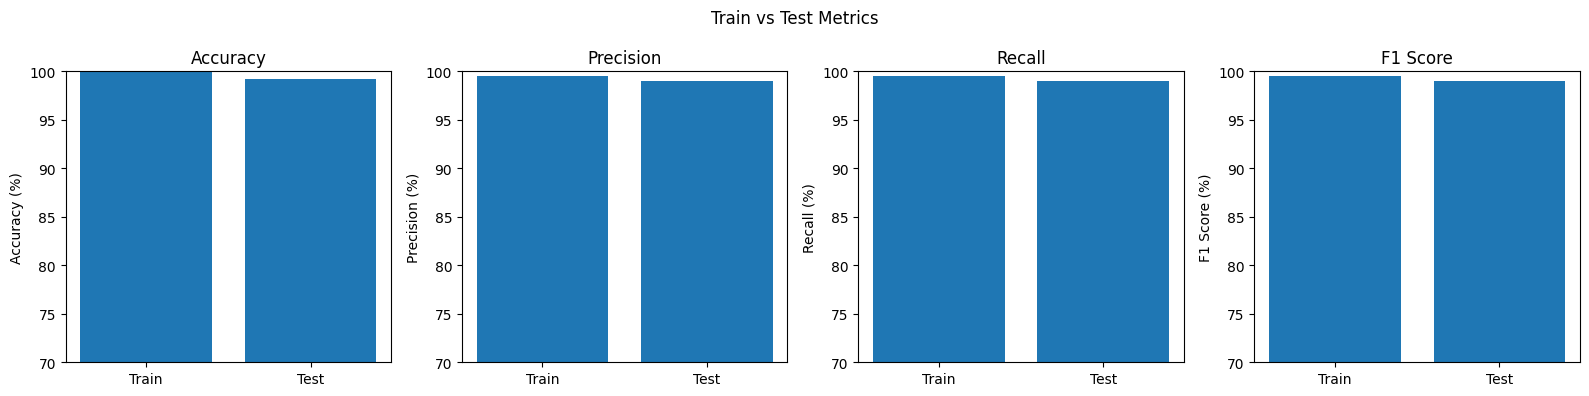

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

CNN_2D_val_precision = np.average(precision_val) * 100
CNN_2D_val_recall = np.average(recall_val) * 100
CNN_2D_val_f1 = np.average(f1_val) * 100

# Calculate metrics for test set
y_pred_test = np.argmax(CNN_2D_best_model.predict(X_2D_test), axis=1)
y_true_test = np.argmax(y_2D_test, axis=1)
CNN_2D_test_precision = precision_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_recall = recall_score(y_true_test, y_pred_test, average='weighted') * 100
CNN_2D_test_f1 = f1_score(y_true_test, y_pred_test, average='weighted') * 100

print('CNN 2D Validation Precision = {:.2f}%'.format(CNN_2D_val_precision))
print('CNN 2D Validation Recall = {:.2f}%'.format(CNN_2D_val_recall))
print('CNN 2D Validation F1 Score = {:.2f}%'.format(CNN_2D_val_f1))
print('CNN 2D Test Precision = {:.2f}%'.format(CNN_2D_test_precision))
print('CNN 2D Test Recall = {:.2f}%'.format(CNN_2D_test_recall))
print('CNN 2D Test F1 Score = {:.2f}%'.format(CNN_2D_test_f1))

# Plot train vs test metrics
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Train vs Test Metrics')

ax1.bar([1, 2], [CNN_2D_train_accuracy, CNN_2D_test_accuracy])
ax1.set_title('Accuracy')
ax1.set_ylabel('Accuracy (%)')
ax1.set_xticks([1, 2])
ax1.set_xticklabels(['Train', 'Test'])
ax1.set_ylim([70, 100])

ax2.bar([1, 2], [CNN_2D_val_precision, CNN_2D_test_precision])
ax2.set_title('Precision')
ax2.set_ylabel('Precision (%)')
ax2.set_xticks([1, 2])
ax2.set_xticklabels(['Train', 'Test'])
ax2.set_ylim([70, 100])

ax3.bar([1, 2], [CNN_2D_val_recall, CNN_2D_test_recall])
ax3.set_title('Recall')
ax3.set_ylabel('Recall (%)')
ax3.set_xticks([1, 2])
ax3.set_xticklabels(['Train', 'Test'])
ax3.set_ylim([70, 100])

ax4.bar([1, 2], [CNN_2D_val_f1, CNN_2D_test_f1])
ax4.set_title('F1 Score')
ax4.set_ylabel('F1 Score (%)')
ax4.set_xticks([1, 2])
ax4.set_xticklabels(['Train', 'Test'])
ax4.set_ylim([70, 100])

plt.tight_layout()
plt.show()